In [123]:
# 共通で利用するライブラリ
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

# warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=3)
pd.options.display.float_format = "{:.3f}".format
pd.set_option("display.max_columns", None)
plt.style.use("seaborn")
plt.rcParams["font.size"] = 14
plt.rcParams["font.family"] = "IPAexGothic"
%matplotlib inline

# 追加するライブラリ
from IPython.display import clear_output
from ipywidgets import Dropdown, SelectMultiple, IntSlider, ToggleButtons, DatePicker
import datetime
from glob import glob
import os
import seaborn as sns

## Ch.03 可視化の仕組みを構築する

- ダッシュボードとは
  - 複数のグラフやデータ等の情報を1つにまとめて、ひと目でデータを把握できるようにするデータ可視化ツール

データ一覧

- m_area.csv
  - 地域マスタ
  - 都道府県情報等
- m_store.csv
  - 店舗マスタ
  - 店舗名等
- tbl_order_202004.csv
  - 注文データ
  - 4月分
- tbl_order_202005.csv
  - 注文データ
  - 5月分
- tbl_order_202006.csv
  - 注文データ
  - 6月分

### Knock21: 店舗を絞り込んで可視化できるようにする

In [124]:
# データの読み込みと結合と修正

# データの読み込み
m_store = pd.read_csv("../support/本章/3章/m_store.csv")
m_area = pd.read_csv("../support/本章/3章/m_area.csv")
order_data = pd.read_csv("../support/本章/3章/tbl_order_202004.csv")

# データの結合
order_data = pd.merge(order_data, m_store, on="store_id", how="left")
order_data = pd.merge(order_data, m_area, on="area_cd", how="left")

# マスタデータにないコードに対応した文字列を設定
# "takeout_name", "status_name"
# 名称の設定（お渡し方法）
order_data.loc[order_data["takeout_flag"] == 0, "takeout_name"] = "デリバリー"
order_data.loc[order_data["takeout_flag"] == 1, "takeout_name"] = "お持ち帰り"

# 名称の設定（注文状態）
order_data.loc[order_data["status"] == 0, "status_name"] = "受付"
order_data.loc[order_data["status"] == 1, "status_name"] = "お支払い済"
order_data.loc[order_data["status"] == 2, "status_name"] = "お渡し済"
order_data.loc[order_data["status"] == 9, "status_name"] = "キャンセル"

print(order_data.shape)
display(order_data)

(233260, 16)


,order_id,store_id,customer_id,coupon_cd,sales_detail_id,order_accept_date,delivered_date,takeout_flag,total_amount,status,store_name,area_cd,wide_area,narrow_area,takeout_name,status_name
0,79339111,49,C26387220,50,67393872,2020-04-01 11:00:00,2020-04-01 11:18:00,1,4144,1,浅草店,TK,東京,東京,お持ち帰り,お支払い済
1,18941733,85,C48773811,26,91834983,2020-04-01 11:00:00,2020-04-01 11:22:00,0,2877,2,目黒店,TK,東京,東京,デリバリー,お渡し済
2,56217880,76,C66287421,36,64409634,2020-04-01 11:00:00,2020-04-01 11:15:00,0,2603,2,本郷店,TK,東京,東京,デリバリー,お渡し済
3,28447783,190,C41156423,19,73032165,2020-04-01 11:00:00,2020-04-01 11:16:00,0,2732,2,栃木店,TO,北関東,栃木,デリバリー,お渡し済
4,32576156,191,C54568117,71,23281182,2020-04-01 11:00:00,2020-04-01 11:53:00,0,2987,2,伊勢崎店,GU,北関東,群馬,デリバリー,お渡し済
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233255,25546308,3,C24617924,46,3700904,2020-04-30 21:58:58,2020-04-30 22:19:58,0,2615,2,足立店,TK,東京,東京,デリバリー,お渡し済
233256,91693481,45,C68997855,6,37852755,2020-04-30 21:58:58,2020-04-30 22:13:58,0,2732,2,池尻店,TK,東京,東京,デリバリー,お渡し済
233257,57908119,36,C16123702,81,90372382,2020-04-30 21:58:58,2020-04-30 22:47:58,0,2363,2,新宿店,TK,東京,東京,デリバリー,お渡し済
233258,7145625,174,C80733640,75,48265986,2020-04-30 21:58:58,2020-04-30 22:32:58,0,2238,2,新座店,SA,埼玉,埼玉,デリバリー,お渡し済


In [125]:
# 複数店舗の詳細表示
# ipywidgetsの機能を実装（ドロップダウン）

def order_by_store(val: list):
    """
    ipywidgetsの実装（ドロップダウン）
    ドロップダウンで店舗を選べるようにする
    """
    clear_output()
    display(dropdown)
    pick_data = order_data.loc[
        (order_data["store_name"] == val["new"]) &
        (order_data["status"].isin([1, 2]))
    ]
    # display(pick_data.head())
    display(pick_data)

store_list = m_store["store_name"].tolist()

dropdown = Dropdown(options=store_list)
dropdown.observe(order_by_store, names="value")
display(dropdown)

Dropdown(options=('昭島店', 'あきる野店', '足立店', '北千住店', '綾瀬店', '荒川店', '東尾久店', '板橋店', '高島平店', '稲城店', '江戸川店', '西葛西店', '…

In [126]:
# 店舗ごとの週単位の売上表示（折れ線グラフ）
# ipywidgetsの機能を実装（ドロップダウン）

def graph_by_store(val: list):
    """
    抽出した各店舗の注文データを可視化
    （折れ線グラフ）
    """
    clear_output()
    display(dropdown2)
    pick_data = order_data.loc[
        (order_data["store_name"] == val["new"]) &
        (order_data["status"].isin([1, 2]))
    ]
    temp = pick_data[["order_accept_date", "total_amount"]].copy()
    temp.loc[:, "order_accept_date"] = pd.to_datetime(temp["order_accept_date"])
    temp.set_index("order_accept_date", inplace=True)
    temp.resample("D").sum().plot()

dropdown2 = Dropdown(options=store_list)
dropdown2.observe(graph_by_store, names="value")
display(dropdown2)

Dropdown(options=('昭島店', 'あきる野店', '足立店', '北千住店', '綾瀬店', '荒川店', '東尾久店', '板橋店', '高島平店', '稲城店', '江戸川店', '西葛西店', '…

### Knock22: 複数店舗の詳細を可視化できるようにする

In [127]:
# 複数店舗の詳細表示
# ipywidgetsの機能を実装（セレクトボックス）

def order_by_multi(val: list):
    """
    オーダー情報に対して、
    セレクトボックスで選んだ店舗の詳細情報を表示する
    """
    clear_output()
    display(select)
    pick_data = order_data.loc[
        (order_data["store_name"].isin(val["new"])) &
        (order_data["status"].isin([1, 2]))
    ]
    display(pick_data)

select = SelectMultiple(options=store_list)
select.observe(order_by_multi, names="value")
display(select)

SelectMultiple(options=('昭島店', 'あきる野店', '足立店', '北千住店', '綾瀬店', '荒川店', '東尾久店', '板橋店', '高島平店', '稲城店', '江戸川店', '西葛…

In [128]:
# 複数店舗のグラフ表示
# ipywidgetsの機能を実装（セレクトボックス）

def graph_by_multi(val: list):
    """
    抽出した複数店舗の注文データを可視化
    （折れ線グラフ）
    """
    clear_output()
    display(select2)

    fig = plt.figure(figsize=(17, 4))
    plt.subplots_adjust(wspace=0.25, hspace=0.6)

    i = 0

    for trg in val["new"]:
        pick_data = order_data[
            (order_data["store_name"] == trg) &
            (order_data["status"].isin([1, 2]))
        ]
        temp = pick_data[["order_accept_date", "total_amount", "store_name"]].copy()
        temp.loc[:, "order_accept_date"] = pd.to_datetime(temp["order_accept_date"])
        temp.set_index("order_accept_date", inplace=True)
        i += 1
        ax = fig.add_subplot(1, len(val["new"]), i)
        ax.plot(temp.resample("D").sum())
        ax.set_title(trg)

select2 = SelectMultiple(options=store_list)
select2.observe(graph_by_multi, names="value")
display(select2)

SelectMultiple(options=('昭島店', 'あきる野店', '足立店', '北千住店', '綾瀬店', '荒川店', '東尾久店', '板橋店', '高島平店', '稲城店', '江戸川店', '西葛…

### Knock23: スライドバーを用いてオーダー件数を調べる

In [129]:
# スライドバーで指定した数値より下回るオーダー件数の店舗表示
# ipywidgetsの機能を実装（スライドバー）

def store_lower(val: list):
    """指定したオーダー件数を下回る店舗を表示"""
    clear_output()
    display(slider)
    temp = order_data.groupby("store_name")
    print(temp.size()[temp.size() < val["new"]])

slider = IntSlider(value=1100, min=1000, max=2000, step=100, description="件数:",)
slider.observe(store_lower, names="value")
display(slider)

IntSlider(value=1100, description='件数:', max=2000, min=1000, step=100)

In [130]:
# スライドバーで指定した数値より上回るオーダー件数の店舗表示
# ipywidgetsの機能を実装（スライドバー）

def store_upper(val: list):
    """指定したオーダー件数を上回る店舗を表示"""
    clear_output()
    display(slider2)
    temp = order_data.groupby("store_name")
    print(temp.size()[temp.size() > val["new"]])


slider2 = IntSlider(value=1600, min=1000, max=2000,step=100, description="件数:",)
slider2.observe(store_lower, names="value")
display(slider2)


IntSlider(value=1600, description='件数:', max=2000, min=1000, step=100)

### Knock24: トグルボタンで地域データを抽出する

In [131]:
# トグルボタンで地域ごとにデータを抽出
# ipywidgetsの機能を実装（トグルボタン）

area_list = m_area["wide_area"].unique()


def order_by_area(val: list):
    """押されたトグルボタンの地域に該当する店舗情報を表示する"""
    clear_output()
    display(toggle)
    pick_data = order_data.loc[
        (order_data["wide_area"] == val["new"]) &
        (order_data["status"].isin([1, 2]))
    ]
    display(pick_data)

toggle = ToggleButtons(options=area_list)
toggle.observe(order_by_area, names="value")
display(toggle)

ToggleButtons(options=('東京', '神奈川', '千葉', '埼玉', '北関東'), value='東京')

In [132]:
# トグルボタンで地域ごとのグラフを表示
# ipywidgetsの機能を実装（トグルボタン）

def graph_by_area(val: list):
    """
    押されたトグルボタンの地域に該当する
    店舗の「total_amount」を集計する
    """
    clear_output()
    display(toggle2)
    pick_data = order_data.loc[
        (order_data["wide_area"] == val["new"]) &
        (order_data["status"].isin([1, 2]))
    ]
    temp = pick_data[["order_accept_date", "total_amount"]].copy()
    temp.loc[:, "order_accept_date"] = pd.to_datetime(temp["order_accept_date"])
    temp.set_index("order_accept_date", inplace=True)
    temp.resample("D").sum().plot()

toggle2 = ToggleButtons(options=area_list)
toggle2.observe(graph_by_area, names="value")
display(toggle2)

ToggleButtons(options=('東京', '神奈川', '千葉', '埼玉', '北関東'), value='東京')

### Knock25: 日付を指定してデータを抽出する

In [133]:
# 日付を指定してデータを抽出
# ipywidgetsの機能を実装（DatePicker）

order_data.loc[:, "order_date"] = pd.to_datetime(order_data["order_accept_date"]).dt.date

def order_by_date(val: list):
    """日付を指定してデータを絞り込む"""
    clear_output()
    display(date_picker)
    pick_data = order_data.loc[
        (order_data["order_date"] == val["new"]) &
        (order_data["status"].isin([1, 2]))
    ]
    print(pick_data.shape)
    display(pick_data)

date_picker = DatePicker(value=datetime.datetime(2020, 4, 1))
date_picker.observe(order_by_date, names="value")
display(date_picker)

DatePicker(value=datetime.datetime(2020, 4, 1, 0, 0), step=1)

In [134]:
# 器官を指定してデータを抽出
# ipywidgetsの機能を実装（DatePicker）

min_date = datetime.date(2020, 4, 1)
max_date = datetime.date(2020, 4, 30)


def order_between_date():
    """
    期間が設定されると呼び出される関数
    指定された期間のデータを抽出して画面に表示する
    """
    clear_output()
    display(date_picker_min)
    display(date_picker_max)
    pick_data = order_data.loc[
        (order_data["order_date"] >= min_date) &
        (order_data["order_date"] <= max_date) &
        (order_data["status"].isin([1, 2]))
    ]
    print(pick_data.shape)
    display(pick_data)


def set_min_date(val: list):
    """最小日（期間自）の日付を変数にセットする関数"""
    global min_date
    min_date = val["new"]
    order_between_date()


def set_max_date(val: list):
    """最大日（期間至）の日付を変数にセットする関数"""
    global max_date
    max_date = val["new"]
    order_between_date()


date_picker_min = DatePicker(value=min_date)
date_picker_min.observe(set_min_date, names="value")
print("最小日")
display(date_picker_min)

date_picker_max = DatePicker(value=max_date)
date_picker_max.observe(set_max_date, names="value")
print("最大日")
display(date_picker_max)


最小日


DatePicker(value=datetime.date(2020, 4, 1), step=1)

最大日


DatePicker(value=datetime.date(2020, 4, 30), step=1)

### Knock26: ストーリーを考えてデータを構築する

In [135]:
# データの再読み込み

# データの読み込み
data_dir = "../support/本章/3章"
tbl_order_file = os.path.join(data_dir, "tbl_order_*.csv")
tbl_order_files = glob(tbl_order_file)

order_all = pd.DataFrame()
for file in tbl_order_files:
    order_tmp = pd.read_csv(file)
    print(f"{file}: {order_tmp.shape}")
    order_all = pd.concat([order_all, order_tmp], axis=0, ignore_index=True)

# 保守用店舗データの削除
order_all = order_all.loc[order_all["store_id"] != 999]

# マスタデータを結合
order_all = pd.merge(order_all, m_store, on="store_id", how="left")
order_all = pd.merge(order_all, m_area, on="area_cd", how="left")

# マスタデータにないコードに対応した文字列の設定
# ["takeout_name"]の追加
order_all.loc[order_all["takeout_flag"] == 0, "takeout_name"] = "デリバリー"
order_all.loc[order_all["takeout_flag"] == 1, "takeout_name"] = "お持ち帰り"
# ["status_name"]の追加
order_all.loc[order_all["status"] == 0, "status_name"] = "受付"
order_all.loc[order_all["status"] == 1, "status_name"] = "お支払済"
order_all.loc[order_all["status"] == 2, "status_name"] = "お渡し済"
order_all.loc[order_all["status"] == 9, "status_name"] = "キャンセル"

# ["order_date"]の追加
order_all.loc[:, "order_date"] = pd.to_datetime(order_all["order_accept_date"]).dt.date

print(order_all.shape)
display(order_all)

../support/本章/3章/tbl_order_202006.csv: (233301, 10)
../support/本章/3章/tbl_order_202004.csv: (233260, 10)
../support/本章/3章/tbl_order_202005.csv: (241139, 10)
(703880, 17)


,order_id,store_id,customer_id,coupon_cd,sales_detail_id,order_accept_date,delivered_date,takeout_flag,total_amount,status,store_name,area_cd,wide_area,narrow_area,takeout_name,status_name,order_date
0,16514392,64,C44271355,49,56527968,2020-06-01 11:00:00,2020-06-01 11:55:00,0,2732,2,西東京店,TK,東京,東京,デリバリー,お渡し済,2020-06-01
1,28342394,12,C98307866,98,46924304,2020-06-01 11:00:00,2020-06-01 11:52:00,0,2064,2,西葛西店,TK,東京,東京,デリバリー,お渡し済,2020-06-01
2,29799587,174,C59484037,45,47054474,2020-06-01 11:00:00,2020-06-01 11:25:00,0,3900,2,新座店,SA,埼玉,埼玉,デリバリー,お渡し済,2020-06-01
3,96960753,23,C57278332,70,60848267,2020-06-01 11:00:00,2020-06-01 11:45:00,0,2750,2,江東店,TK,東京,東京,デリバリー,お渡し済,2020-06-01
4,52147209,7,C36890849,80,20633593,2020-06-01 11:00:00,2020-06-01 11:23:00,0,2328,2,東尾久店,TK,東京,東京,デリバリー,お渡し済,2020-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703875,47039360,154,C39765066,90,27121351,2020-05-31 21:58:58,2020-05-31 22:42:58,1,2363,1,入間店,SA,埼玉,埼玉,お持ち帰り,お支払済,2020-05-31
703876,61054188,94,C19465010,41,61513298,2020-05-31 21:58:58,2020-05-31 22:40:58,0,2112,2,鎌倉店,KN,神奈川,神奈川,デリバリー,お渡し済,2020-05-31
703877,45288914,11,C23883838,40,65359139,2020-05-31 21:58:58,2020-05-31 22:38:58,0,3838,2,江戸川店,TK,東京,東京,デリバリー,お渡し済,2020-05-31
703878,41608372,149,C48350551,43,42138977,2020-05-31 21:58:58,2020-05-31 22:52:58,0,1899,2,松戸店,CH,千葉,千葉,デリバリー,お渡し済,2020-05-31


In [136]:
# ["store_id"]別、["customer_id"]ごとの["total_amount"]の統計量

order_all.groupby(["store_id", "customer_id"])["total_amount"].describe()
# 1m55s

count     mean      std      min      25%      50%  \
store_id customer_id                                                       
1        C00244531   14.000 3319.571  860.263 1882.000 2515.750 3679.500   
         C00493736    7.000 3318.143  922.547 2471.000 2719.000 2987.000   
         C01249550    8.000 2664.375  848.340 1857.000 2029.750 2379.500   
         C02241044    6.000 3653.833 1184.408 2252.000 2571.000 3979.500   
         C02859946    9.000 3216.556  858.216 1857.000 2647.000 3586.000   
...                     ...      ...      ...      ...      ...      ...   
196      C84471901   66.000 2781.773  805.412  698.000 2255.500 2677.000   
         C88251581   58.000 3054.466  984.291  698.000 2328.000 2987.000   
         C90878439   73.000 2851.068  852.861  698.000 2154.000 2615.000   
         C97487773   61.000 2988.525  892.917  698.000 2238.000 2750.000   
         C98683987   71.000 2878.042  913.949  698.000 2154.000 2677.000   

                          75%      max  
store_id customer_id                    
1        C00244531   3901.000 4462.000  
         C00493736   3615.500 5100.000  
         C01249550   3132.750 3931.000  
         C02241044   4683.750 4692.000  
         C02859946   3900.000 3931.000  
...                       ...      ...  
196      C84471901   3172.250 4659.000  
         C88251581   3891.250 4659.000  
         C90878439   3865.000 4659.000  
         C97487773   3900.000 4659.000  
         C98683987   3530.000 4659.000  

[41336 rows x 8 columns]

In [137]:
# 売上上位店舗と売上下位店舗の表示
# 売上が成立したデータ（status=1（お支払済）, status=2（お渡し済））
# の["total_amount"]の合計値から計算する

# 売上が成立したデータを抽出
summary_df = order_all.loc[order_all["status"].isin([1, 2])]
# ["store_id"]別に["total_amount"]を集計
store_summary_df = summary_df.groupby(["store_id"])["total_amount"].sum()

# store_summary_dfにm_storeを結合
store_summary_df = pd.merge(store_summary_df, m_store, on="store_id", how="left")

# 表示
print("売上上位10店舗")
display(store_summary_df.sort_values("total_amount", ascending=False).head(10))
print("売上下位10店舗")
display(store_summary_df.sort_values("total_amount", ascending=True).head(10))

売上上位10店舗


,store_id,total_amount,store_name,area_cd
47,48,11992501,上野店,TK
190,191,11821224,伊勢崎店,GU
122,123,11320012,栄店,KN
67,68,11272728,八王子店,TK
62,63,11201742,西多摩店,TK
126,127,11179377,戸塚店,KN
99,100,11128515,中原店,KN
43,44,11079128,世田谷店,TK
172,173,11001277,戸田店,SA
78,79,10989669,三鷹店,TK


売上下位10店舗


,store_id,total_amount,store_name,area_cd
100,101,5350100,宮前店,KN
75,76,5701753,本郷店,TK
2,3,5712210,足立店,TK
151,152,5723229,四街道店,CH
11,12,5808496,西葛西店,TK
195,196,5901819,前橋店,GU
185,186,6087730,足利店,TO
161,162,6158812,越谷店,SA
69,70,6242227,東久留米店,TK
145,146,6307301,成田店,CH


In [138]:
# キャンセル率が高い店舗と低い店舗の表示

cancel_df = pd.DataFrame()
cancel_cnt = order_all.loc[order_all["status"]  == 9].groupby(["store_id"])["store_id"].count()
order_cnt = order_all.loc[order_all["status"].isin([1, 2, 9])].groupby(["store_id"])["store_id"].count()

cancel_rate = (cancel_cnt / order_cnt) * 100

cancel_df["cancel_rate"] = cancel_rate
cancel_df = pd.merge(cancel_df, m_store, on="store_id", how="left")

print("キャンセル率が低い店舗")
display(cancel_df.sort_values("cancel_rate", ascending=True).head(10))
print("キャンセル率が高い店舗")
display(cancel_df.sort_values("cancel_rate", ascending=False).head(10))

キャンセル率が低い店舗


,store_id,cancel_rate,store_name,area_cd
121,122,16.464,港北店,KN
130,131,16.641,我孫子店,CH
119,120,16.702,金沢店,KN
152,153,17.036,上尾店,SA
19,20,17.128,王子店,TK
40,41,17.206,荻窪店,TK
68,69,17.296,羽村店,TK
122,123,17.314,栄店,KN
33,34,17.321,恵比寿店,TK
181,182,17.322,那珂店,IB


キャンセル率が高い店舗


,store_id,cancel_rate,store_name,area_cd
7,8,20.306,板橋店,TK
138,139,20.149,白井店,CH
131,132,19.948,市川店,CH
156,157,19.929,川越店,SA
95,96,19.658,川崎店,KN
65,66,19.628,石神井店,TK
75,76,19.534,本郷店,TK
9,10,19.481,稲城店,TK
18,19,19.470,赤羽店,TK
161,162,19.469,越谷店,SA


### Knock27: キャンセルの理由を分析する

In [139]:
# キャンセル率が
# 高い店舗（store_id=8）と
# 低い店舗（store_id=122）の
# 配達完了までの時間

def calc_delta(t):
    """
    注文を受けてから配達完了までの時間を計算する
    """
    t1, t2, = t
    delta = t2 - t1
    # 配達完了までの時間（min）
    return delta.total_seconds()/60

# 配達完了時間 - 受付時間
order_all.loc[:, "order_accept_datetime"] = pd.to_datetime(order_all["order_accept_date"])
order_all.loc[:, "delivered_datetime"] = pd.to_datetime(order_all["delivered_date"])
order_all.loc[:, "delta"] = order_all[["order_accept_datetime", "delivered_datetime"]].apply(calc_delta, axis=1)

# status=2（デリバリー）かつ
# 高い店舗（store_id=8）と低い店舗（store_id=122）の抽出
delivery_df = order_all.loc[
    (order_all["status"] == 2) &
    (order_all["store_id"].isin([8, 122]))
]

delivery_df.groupby(["store_id"])["delta"].mean()
# 40s

store_id
8     47.676
122   20.195
Name: delta, dtype: float64

### Knock28: 仮設を検証する

- キャンセル率と配達時間に相関があるか

In [140]:
# 全店舗のは相立つ完了までの時間の集計

temp_cancel = cancel_df.copy()
temp_delivery = order_all.loc[order_all["status"] == 2].groupby(["store_id"])["delta"].mean()
check_df = pd.merge(temp_cancel, temp_delivery, on="store_id", how="left")
display(check_df)

,store_id,cancel_rate,store_name,area_cd,delta
0,1,19.026,昭島店,TK,34.396
1,2,18.660,あきる野店,TK,34.836
2,3,18.432,足立店,TK,34.462
3,4,18.320,北千住店,TK,34.492
4,5,18.257,綾瀬店,TK,34.152
...,...,...,...,...,...
191,192,18.376,太田店,GU,34.261
192,193,18.762,桐生店,GU,34.669
193,194,17.964,高崎店,GU,34.823
194,195,19.454,館林店,GU,34.671


In [141]:
# 全店舗の「キャンセル率」と「配達完了までの時間」の抽出
temp_chk = check_df[["cancel_rate", "delta"]]

# 全店舗の「キャンセル率」と「配達完了までの時間」の相関係数
display(temp_chk.corr())

,cancel_rate,delta
cancel_rate,1.000,0.659
delta,0.659,1.000


In [142]:
# キャンセル率が高い（第3四分位以上）群と
# キャンセル率が低い（第1四分位）群での相関係数

# キャンセル率が高い（第3四分位以上）群の抽出
# しきい値（第3四分位）の取得
th_high = check_df["cancel_rate"].quantile(0.75)
# check_dfからしきい値以上のデータを抽出
temp_chk = check_df.loc[(check_df["cancel_rate"] >= th_high)]
temp_chk = temp_chk[["cancel_rate", "delta"]]
# 相関係数の計算
display(temp_chk.corr())

# キャンセル率が低い（第1四分位以下）群の抽出
# しきい値（第1四分位）の取得
th_low = check_df["cancel_rate"].quantile(0.25)
# check_dfからしきい値以下のデータを抽出
temp_chk = check_df.loc[(check_df["cancel_rate"] <= th_low)]
temp_chk = temp_chk[["cancel_rate", "delta"]]
# 相関係数の計算
display(temp_chk.corr())

,cancel_rate,delta
cancel_rate,1.000,0.787
delta,0.787,1.000


,cancel_rate,delta
cancel_rate,1.000,0.766
delta,0.766,1.000


- 傾向とつかみ
- 仮設を立てて
- 検証する
- サイクルを地道に繰り返す

### Knock29: ストーリーをもとにパーツやデータを組合せてダッシュボードを作る

In [143]:
# 準備処理

# 環境変数
target_store = ""
min_date = datetime.date(2020, 4, 1)
max_date = datetime.date(2020, 4, 30)

In [154]:
# 画面の描画処理

def make_board():
    """"""
    clear_output()
    display(toggle_db)

    # データ処理
    pick_order_data = order_all.loc[
        (order_all["store_name"] == target_store) &
        (order_all["order_date"] >= min_date) &
        (order_all["order_date"] <= max_date) &
        (order_all["status"].isin([1, 2]))
    ]
    pick_cancel_data = order_all.loc[
        (order_all["store_name"] == target_store) &
        (order_all["order_date"] >= min_date) &
        (order_all["order_date"] <= max_date) &
        (order_all["status"] == 9)
    ]
    pick_order_all = order_all.loc[
        (order_all["order_date"] >= min_date) &
        (order_all["order_date"] <= max_date) &
        (order_all["status"].isin([1, 2]))
    ]
    pick_cancel_all = order_all.loc[
        (order_all["order_date"] >= min_date) &
        (order_all["order_date"] <= max_date) &
        (order_all["status"] == 9)
    ]

    store_order_cnt = len(pick_order_data)
    store_customer_cnt = len(pick_cancel_data["customer_id"].unique())
    store_cancel_rate = (
        len(pick_cancel_data) / (len(pick_order_data) + len(pick_cancel_data))
    ) * 100
    delivery_time = pick_order_data.loc[pick_order_data["status"] == 2]["delta"].mean()
    delivery_time_all = pick_order_all.loc[pick_order_all["status"] == 2]["delta"].mean()

    # 画面の描画処理
    temp = pick_order_data[["order_date", "total_amount"]].copy()
    temp.loc[:, "order_date"] = pd.to_datetime(temp["order_date"])
    temp.set_index("order_date", inplace=True)

    print("================================================================================")
    str_out = f"<<{target_store}>> [対象期間]:{min_date}~{max_date}"
    str_out = str_out + f" [オーダー件数]:{store_order_cnt}件 [利用顧客数]:{store_customer_cnt}人"
    print(str_out)
    print("================================================================================")
    print("==日次の売上==")
    display(temp.resample("D").sum())
    print("================================================================================")
    str_out = f"[期間売上総額]:{'{:,}'.format(temp['total_amount'].sum())}"
    str_out = str_out + f" [キャンセル総額]:{'{:,}'.format(pick_cancel_data['total_amount'].sum())}"
    str_out = str_out + f" [キャンセル率]:{round(store_cancel_rate, 2)}%"
    print(str_out)

    str_out = f"[平均配達完了時間]:{round(delivery_time, 2)}min"
    str_out = str_out + f" [全店舗平均配達時間]:{round(delivery_time_all, 2)}min"
    print(str_out)
    print("================================================================================")

    # グラフの作成処理
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.distplot(temp.resample("D").sum(), ax=ax1, kde=False)
    ax1.set_title("売上（日次）ヒストグラム")

    sns.countplot(x="order_date", data=pick_cancel_data, ax=ax2)
    ax2.set_title("キャンセル数（日次）")

    fig, (ax3) = plt.subplots(1, 1, figsize=(20, 5))
    sns.boxplot(x="order_date", y="total_amount", data=pick_order_data)
    ax3.set_title("オーダー状況 箱ひげ図")

    plt.show()


In [155]:
# カレンダー変更時の処理

def change_date_min(val):
    """"""
    global min_date
    min_date = val["new"]
    make_board()

def change_date_max(val):
    """"""
    global max_date
    max_date = val["new"]
    make_board()

In [156]:
# ドロップダウン変更時の処理

def change_dropdown(val):
    """"""
    global target_store
    target_store = val["new"]

    # 期間指定機能
    date_picker_min = DatePicker(value=min_date)
    date_picker_min.observe(change_date_min, names="value")
    print("期間")
    date_picker_max = DatePicker(value=max_date)
    date_picker_max.observe(change_date_max, names="value")

    display(date_picker_min, date_picker_max)

In [157]:
# 地域トグルボタンの処理

def order_by_area(val):
    """"""
    clear_output()
    display(toggle_db)

    # 選択された地域の店舗リストを作成する
    store_list = order_all.loc[order_all["wide_area"] == val["new"]]["store_name"].unique()
    
    # 作成された店舗リストでドロップダウンを作成する
    dropdown = Dropdown(options=store_list)
    dropdown.observe(change_dropdown, names="value")

    display(dropdown)

ToggleButtons(options=('東京', '神奈川', '千葉', '埼玉', '北関東'), value='東京')

<<渋谷店>> [対象期間]:2020-04-02~2020-04-30 [オーダー件数]:899件 [利用顧客数]:140人
==日次の売上==


,total_amount
order_date,
2020-04-02,79686
2020-04-03,91252
2020-04-04,87663
2020-04-05,81120
2020-04-06,94598
2020-04-07,89077
2020-04-08,74257
2020-04-09,88273
2020-04-10,87819


[期間売上総額]:2,563,645 [キャンセル総額]:529,234 [キャンセル率]:17.07%
[平均配達完了時間]:35.09min [全店舗平均配達時間]:34.38min


/Users/takeru/Library/CloudStorage/OneDrive-個人用/Learn/Python/python-practical-machine-learning-system-100knocks/venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


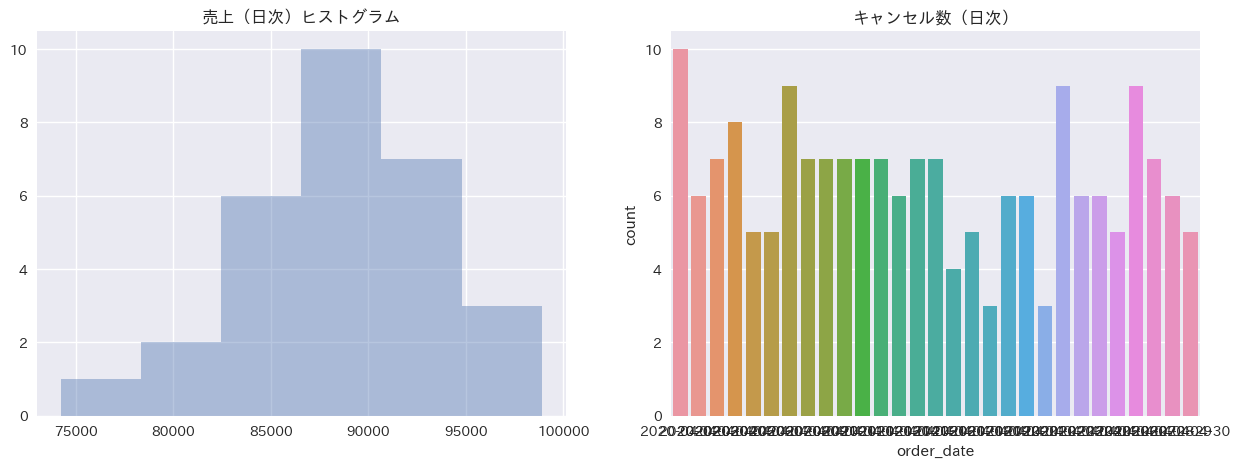

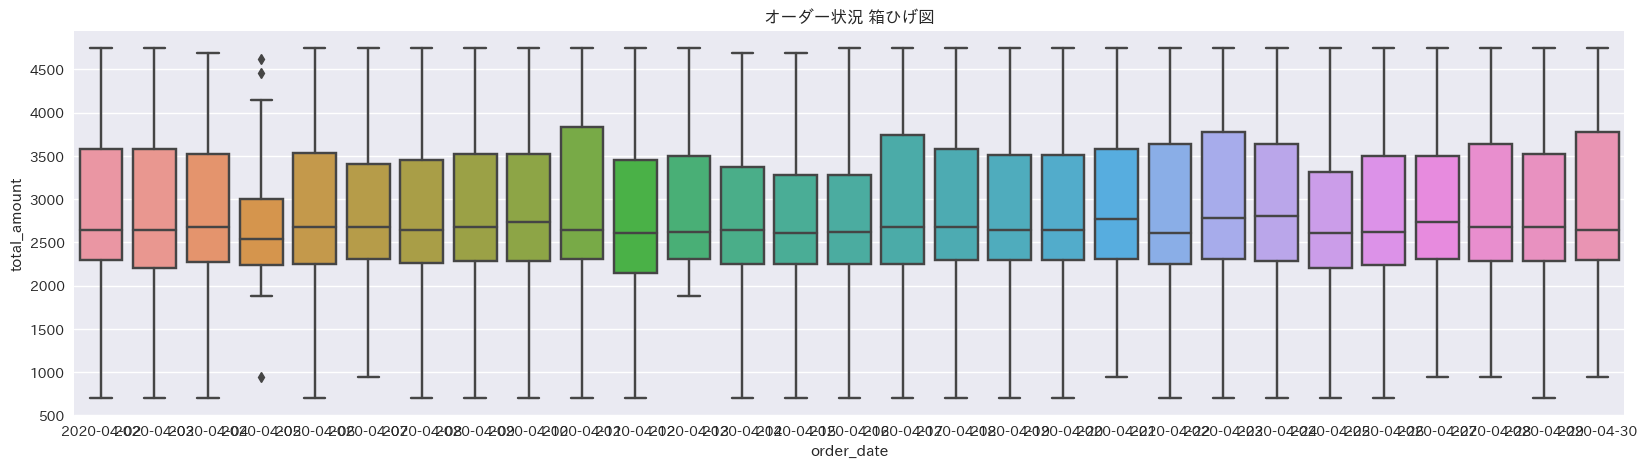

In [158]:
# トグルボタンを表示

toggle_db = ToggleButtons(options=area_list)
toggle_db.observe(order_by_area, names="value")
display(toggle_db)

### Knock30: ダッシュボードを改善する

- 地区ごとに集計してほしい
- キャンセル率、配達完了までの時間を地域ごとにランキング形式で表示してほしい

In [192]:
# 地域別、「配達完了までの時間」ランキング

cal_orders_base = order_all.loc[order_all["status"].isin([1, 2])]

# 「配達完了までの時間」地域ランキング
print("===「配達完了までの時間」地域ランキング ===")
display(
    pd.DataFrame(
        cal_orders_base.groupby(["narrow_area"])["delta"].mean().sort_values()
    )
)
print("--- 地域ごとのTOP5 ---")
for area in m_area["area_cd"]:
    temp = cal_orders_base.loc[cal_orders_base["area_cd"] == area]
    temp = temp.groupby(["store_id"])["delta"].mean().sort_values()
    temp = pd.merge(temp, m_store, on="store_id", how="left")[["store_name", "delta"]]
    area_name = m_area.loc[m_area["area_cd"] == area, "narrow_area"].values
    print(f"<{area_name}>")
    display(temp.head())

===「配達完了までの時間」地域ランキング ===


,delta
narrow_area,
茨城,32.249
神奈川,33.707
東京,34.491
群馬,34.500
栃木,34.544
埼玉,34.754
千葉,34.948


--- 地域ごとのTOP5 ---
<['東京']>


,store_name,delta
0,羽村店,20.238
1,荻窪店,20.302
2,恵比寿店,20.306
3,王子店,20.519
4,自由が丘店,33.999


<['神奈川']>


,store_name,delta
0,金沢店,20.143
1,港北店,20.241
2,栄店,20.314
3,南足柄店,33.955
4,高座店,34.017


<['千葉']>


,store_name,delta
0,我孫子店,20.030
1,富津店,33.881
2,流山店,33.945
3,茂原店,34.125
4,習志野店,34.162


<['埼玉']>


,store_name,delta
0,上尾店,20.231
1,入間店,33.878
2,坂戸店,34.087
3,鴻巣店,34.350
4,八潮店,34.356


<['茨城']>


,store_name,delta
0,那珂店,20.454
1,日立店,34.370
2,守谷店,34.417
3,取手店,34.453
4,水戸店,34.620


<['栃木']>


,store_name,delta
0,宇都宮店,34.082
1,栃木店,34.352
2,佐野店,34.671
3,足利店,34.792
4,小山店,34.852


<['群馬']>


,store_name,delta
0,前橋店,33.866
1,太田店,34.486
2,伊勢崎店,34.557
3,館林店,34.559
4,桐生店,34.619


In [193]:
display(check_df)

,store_id,cancel_rate,store_name,area_cd,delta
0,1,19.026,昭島店,TK,34.396
1,2,18.660,あきる野店,TK,34.836
2,3,18.432,足立店,TK,34.462
3,4,18.320,北千住店,TK,34.492
4,5,18.257,綾瀬店,TK,34.152
...,...,...,...,...,...
191,192,18.376,太田店,GU,34.261
192,193,18.762,桐生店,GU,34.669
193,194,17.964,高崎店,GU,34.823
194,195,19.454,館林店,GU,34.671


In [196]:
# 地域別、「キャンセル率」ランキング

base_df = pd.merge(check_df, m_store, on="area_cd", how="left")
base_df = pd.merge(base_df, m_area, on="area_cd", how="left")

# 「キャンセル率」地域ランキング
print("===「キャンセル率」地域ランキング ===")
display(
    pd.DataFrame(
        base_df.groupby(["narrow_area"])["cancel_rate"].mean().sort_values()
    )
)
print("--- 地域ごとのTOP5 ---")
for area in m_area["area_cd"]:
    temp = check_df.loc[check_df["area_cd"] == area]
    temp = temp.groupby(["store_id"])["cancel_rate"].mean().sort_values()
    temp = pd.merge(temp, m_store, on="store_id")[["store_name", "cancel_rate"]]
    area_name = m_area.loc[m_area["area_cd"] == area, "narrow_area"].values
    print(f"<{area_name}>")
    display(temp.head())

===「キャンセル率」地域ランキング ===


,cancel_rate
narrow_area,
神奈川,18.225
茨城,18.248
千葉,18.364
栃木,18.376
埼玉,18.443
東京,18.452
群馬,18.519


--- 地域ごとのTOP5 ---
<['東京']>


,store_name,cancel_rate
0,王子店,17.128
1,荻窪店,17.206
2,羽村店,17.296
3,恵比寿店,17.321
4,赤坂店,17.354


<['神奈川']>


,store_name,cancel_rate
0,港北店,16.464
1,金沢店,16.702
2,栄店,17.314
3,愛甲店,17.457
4,磯子店,17.460


<['千葉']>


,store_name,cancel_rate
0,我孫子店,16.641
1,富津店,17.487
2,若葉店,17.490
3,成田店,17.543
4,佐倉店,17.568


<['埼玉']>


,store_name,cancel_rate
0,上尾店,17.036
1,草加店,17.446
2,大宮店,17.660
3,和光店,17.782
4,川口店,17.856


<['茨城']>


,store_name,cancel_rate
0,那珂店,17.322
1,守谷店,17.326
2,日立店,18.262
3,取手店,18.549
4,水戸店,18.945


<['栃木']>


,store_name,cancel_rate
0,足利店,17.451
1,宇都宮店,17.847
2,小山店,18.771
3,栃木店,18.896
4,佐野店,18.915


<['群馬']>


,store_name,cancel_rate
0,伊勢崎店,17.753
1,高崎店,17.964
2,太田店,18.376
3,桐生店,18.762
4,前橋店,18.803
